# Direct Forecasting with future known features
Conda environment: `time-series`   
20 May 2024  

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

from feature_engine.datetime import DatetimeFeatures

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [5]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"
...,...
2015-02-28 19:00:00,"9,596.7771"
2015-02-28 20:00:00,"8,883.2303"
2015-02-28 21:00:00,"8,320.2605"


In [6]:
# Split into train and test. We leave 2015 in the test set
end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

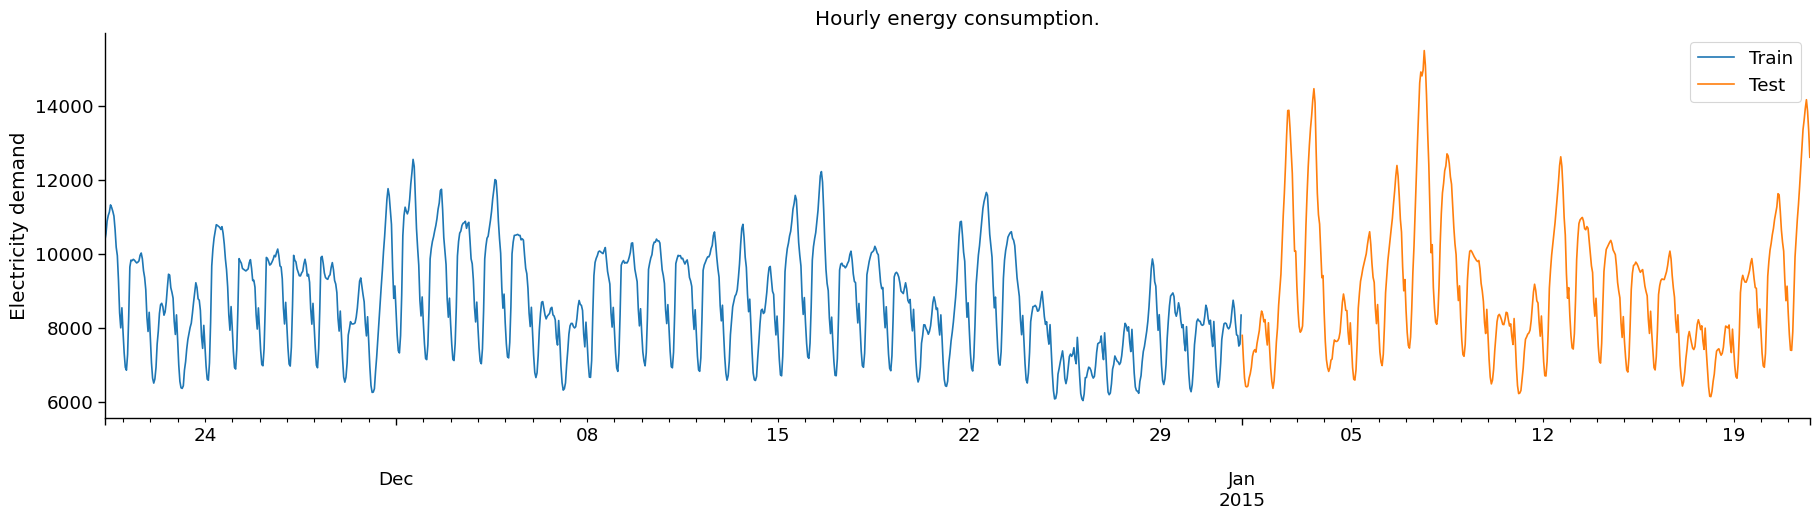

In [7]:
fig, ax = plt.subplots()

X_train.tail(1000).plot(ax=ax)
X_test.head(500).plot(ax=ax)

ax.set_title('Hourly energy consumption.')
ax.legend(["Train", "Test"])
ax.set_xlabel("")
ax.set_ylabel("Electricity demand")

plt.show()

## 2) Direct Forecasting with future known features

In [11]:
HORIZON = 24

# Lasso regression model
lasso_model = Lasso(random_state=9, max_iter=1000)

In [9]:
# We will create a df used as a template to create the datetime features
datetime_df = pd.DataFrame(X_train.index, index=X_train.index)
datetime_df

,date_time
date_time,
2002-01-01 00:00:00,2002-01-01 00:00:00
2002-01-01 01:00:00,2002-01-01 01:00:00
2002-01-01 02:00:00,2002-01-01 02:00:00
2002-01-01 03:00:00,2002-01-01 03:00:00
2002-01-01 04:00:00,2002-01-01 04:00:00
...,...
2014-12-31 19:00:00,2014-12-31 19:00:00
2014-12-31 20:00:00,2014-12-31 20:00:00
2014-12-31 21:00:00,2014-12-31 21:00:00


In [10]:
datetime_f = DatetimeFeatures(
    variables="date_time",
    features_to_extract=["month", "day_of_week", "hour"],
    drop_original=True,
)

# Let's explore the output
datetime_f.fit_transform(datetime_df)

,date_time_month,date_time_day_of_week,date_time_hour
date_time,,,
2002-01-01 00:00:00,1,1,0
2002-01-01 01:00:00,1,1,1
2002-01-01 02:00:00,1,1,2
2002-01-01 03:00:00,1,1,3
2002-01-01 04:00:00,1,1,4
...,...,...,...
2014-12-31 19:00:00,12,2,19
2014-12-31 20:00:00,12,2,20
2014-12-31 21:00:00,12,2,21


In [12]:
forecaster = ForecasterAutoregDirect(
    regressor=lasso_model,        # the machine learning model
    lags=24,                      # the lag features to create
    transformer_exog=datetime_f,  # to get the datetime features
    steps=HORIZON,
    forecaster_id="direct",
)

# Train
forecaster.fit(
    y=X_train["demand"],  # the series for the lags
    exog=datetime_df,     # the datetime for the datetime features
)

forecaster

/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e+09, tolerance: 3.156e+07
  model = cd_fast.enet_coordinate_descent(
/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.134e+09, tolerance: 3.156e+07
  model = cd_fast.enet_coordinate_descent(
/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

ForecasterAutoregDirect 
Regressor: Lasso(random_state=9) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'hour'],
                 variables='date_time') 
Weight function included: False 
Window size: 24 
Maximum steps predicted: 24 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['date_time'] 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 9, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-20 18:17:14 
Last fit date: 2024-05-20 18:18:21 
Skforecast version: 0.11.0 
Python 

### 2.1) Explore X & y

In [13]:
Xt, yt = forecaster.create_train_X_y(
    y=X_train["demand"],
    exog=datetime_df,
)

Xt.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,date_time_month_step_1,date_time_day_of_week_step_1,date_time_hour_step_1,date_time_month_step_2,date_time_day_of_week_step_2,date_time_hour_step_2,date_time_month_step_3,date_time_day_of_week_step_3,date_time_hour_step_3,date_time_month_step_4,date_time_day_of_week_step_4,date_time_hour_step_4,date_time_month_step_5,date_time_day_of_week_step_5,date_time_hour_step_5,date_time_month_step_6,date_time_day_of_week_step_6,date_time_hour_step_6,date_time_month_step_7,date_time_day_of_week_step_7,date_time_hour_step_7,date_time_month_step_8,date_time_day_of_week_step_8,date_time_hour_step_8,date_time_month_step_9,date_time_day_of_week_step_9,date_time_hour_step_9,date_time_month_step_10,date_time_day_of_week_step_10,date_time_hour_step_10,date_time_month_step_11,date_time_day_of_week_step_11,date_time_hour_step_11,date_time_month_step_12,date_time_day_of_week_step_12,date_time_hour_step_12,date_time_month_step_13,date_time_day_of_week_step_13,date_time_hour_step_13,date_time_month_step_14,date_time_day_of_week_step_14,date_time_hour_step_14,date_time_month_step_15,date_time_day_of_week_step_15,date_time_hour_step_15,date_time_month_step_16,date_time_day_of_week_step_16,date_time_hour_step_16,date_time_month_step_17,date_time_day_of_week_step_17,date_time_hour_step_17,date_time_month_step_18,date_time_day_of_week_step_18,date_time_hour_step_18,date_time_month_step_19,date_time_day_of_week_step_19,date_time_hour_step_19,date_time_month_step_20,date_time_day_of_week_step_20,date_time_hour_step_20,date_time_month_step_21,date_time_day_of_week_step_21,date_time_hour_step_21,date_time_month_step_22,date_time_day_of_week_step_22,date_time_hour_step_22,date_time_month_step_23,date_time_day_of_week_step_23,date_time_hour_step_23,date_time_month_step_24,date_time_day_of_week_step_24,date_time_hour_step_24
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-02 23:00:00,"6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,221.4173","6,013.4966","6,022.0166","6,079.7077","6,147.3210","6,104.9250","5,938.3376","5,698.1520","5,457.7706","5,574.7319","5,385.8511","5,497.7329","5,815.5378","6,406.5430","7,165.9742","6,919.3661",1,2,0,1,2,1,1,2,2,1,2,3,1,2,4,1,2,5,1,2,6,1,2,7,1,2,8,1,2,9,1,2,10,1,2,11,1,2,12,1,2,13,1,2,14,1,2,15,1,2,16,1,2,17,1,2,18,1,2,19,1,2,20,1,2,21,1,2,22,1,2,23
2002-01-03 00:00:00,"6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,221.4173","6,013.4966","6,022.0166","6,079.7077","6,147.3210","6,104.9250","5,938.3376","5,698.1520","5,457.7706","5,574.7319","5,385.8511","5,497.7329","5,815.5378","6,406.5430","7,165.9742",1,2,1,1,2,2,1,2,3,1,2,4,1,2,5,1,2,6,1,2,7,1,2,8,1,2,9,1,2,10,1,2,11,1,2,12,1,2,13,1,2,14,1,2,15,1,2,16,1,2,17,1,2,18,1,2,19,1,2,20,1,2,21,1,2,22,1,2,23,1,3,0
2002-01-03 01:00:00,"6,990.8264","6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,221.4173","6,013.4966","6,022.0166","6,079.7077","6,147.3210","6,104.9250","5,938.3376","5,698.1520","5,457.7706","5,574.7319","5,385.8511","5,497.7329","5,815.5378","6,406.5430",1,2,2,1,2,3,1,2,4,1,2,5,1,2,6,1,2,7,1,2,8,1,2,9,1,2,10,1,2,11,1,2,12,1,2,13,1,2,14,1,2,15,1,2,16,1,2,17,1,2,18,1,2,19,1,2,20,1,2,21,1,2,22,1,2,23,1,3,0,1,3,1
2002-01-03 02:00:00,"6,382.9150","6,990.8264","6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,221.4173","6,013.4966","6,022.0166","6,079.7077","6,147.3210","6,104.9250","5,938.3376","5,698.1520","5,457.7706","5,574.7319","5,385.8511","5,497.7329","5,815.5378",1,2,3,1,2,4,1,2,5,1,2,6,1,2,7,1,2,8,1,2,9,1,2,10,1,2,11,1,2,12,1,2,13,1,2,14,1,2,15,1,2,16,1,2,17,1,2,18,1,2,19

In [14]:
yt

{1: date_time
 2002-01-02 00:00:00   6,579.2199
 2002-01-02 01:00:00   6,990.8264
 2002-01-02 02:00:00   6,382.9150
 2002-01-02 03:00:00   5,896.9281
 2002-01-02 04:00:00   5,853.9371
                          ...    
 2014-12-30 20:00:00   8,214.0386
 2014-12-30 21:00:00   7,768.0877
 2014-12-30 22:00:00   7,504.2576
 2014-12-30 23:00:00   8,181.2807
 2014-12-31 00:00:00   7,566.1353
 Freq: H, Name: y_step_1, Length: 113905, dtype: float64,
 2: date_time
 2002-01-02 01:00:00   6,990.8264
 2002-01-02 02:00:00   6,382.9150
 2002-01-02 03:00:00   5,896.9281
 2002-01-02 04:00:00   5,853.9371
 2002-01-02 05:00:00   6,344.8346
                          ...    
 2014-12-30 21:00:00   7,768.0877
 2014-12-30 22:00:00   7,504.2576
 2014-12-30 23:00:00   8,181.2807
 2014-12-31 00:00:00   7,566.1353
 2014-12-31 01:00:00   6,985.0524
 Freq: H, Name: y_step_2, Length: 113905, dtype: float64,
 3: date_time
 2002-01-02 02:00:00   6,382.9150
 2002-01-02 03:00:00   5,896.9281
 2002-01-02 04:00:00   5,8

### 2.2) Predict

In [18]:
forecast_point = '2015-01-01 00:00:00'
forecast_end = '2015-01-01 23:59:59'

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="1H",
)

print(f"Index length: {len(index)}")
index

Index length: 24


DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               '2015-01-01 10:00:00', '2015-01-01 11:00:00',
               '2015-01-01 12:00:00', '2015-01-01 13:00:00',
               '2015-01-01 14:00:00', '2015-01-01 15:00:00',
               '2015-01-01 16:00:00', '2015-01-01 17:00:00',
               '2015-01-01 18:00:00', '2015-01-01 19:00:00',
               '2015-01-01 20:00:00', '2015-01-01 21:00:00',
               '2015-01-01 22:00:00', '2015-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [19]:
# for the exog
exog = pd.DataFrame(
    X_test.loc[index].index,
    columns = ["date_time"],
    index = index,
)

exog

,date_time
2015-01-01 00:00:00,2015-01-01 00:00:00
2015-01-01 01:00:00,2015-01-01 01:00:00
2015-01-01 02:00:00,2015-01-01 02:00:00
2015-01-01 03:00:00,2015-01-01 03:00:00
2015-01-01 04:00:00,2015-01-01 04:00:00
2015-01-01 05:00:00,2015-01-01 05:00:00
2015-01-01 06:00:00,2015-01-01 06:00:00
2015-01-01 07:00:00,2015-01-01 07:00:00
2015-01-01 08:00:00,2015-01-01 08:00:00
2015-01-01 09:00:00,2015-01-01 09:00:00


In [21]:
predictions = forecaster.predict(
    steps=HORIZON,
    exog=exog,
)

pd.DataFrame(predictions).reset_index()

,index,pred
0,2015-01-01 00:00:00,"8,250.6732"
1,2015-01-01 01:00:00,"8,013.8712"
2,2015-01-01 02:00:00,"7,619.9581"
3,2015-01-01 03:00:00,"7,363.1134"
4,2015-01-01 04:00:00,"7,512.8153"
5,2015-01-01 05:00:00,"7,884.9983"
6,2015-01-01 06:00:00,"8,450.7058"
7,2015-01-01 07:00:00,"8,672.1484"
8,2015-01-01 08:00:00,"8,743.6634"
9,2015-01-01 09:00:00,"8,803.3015"


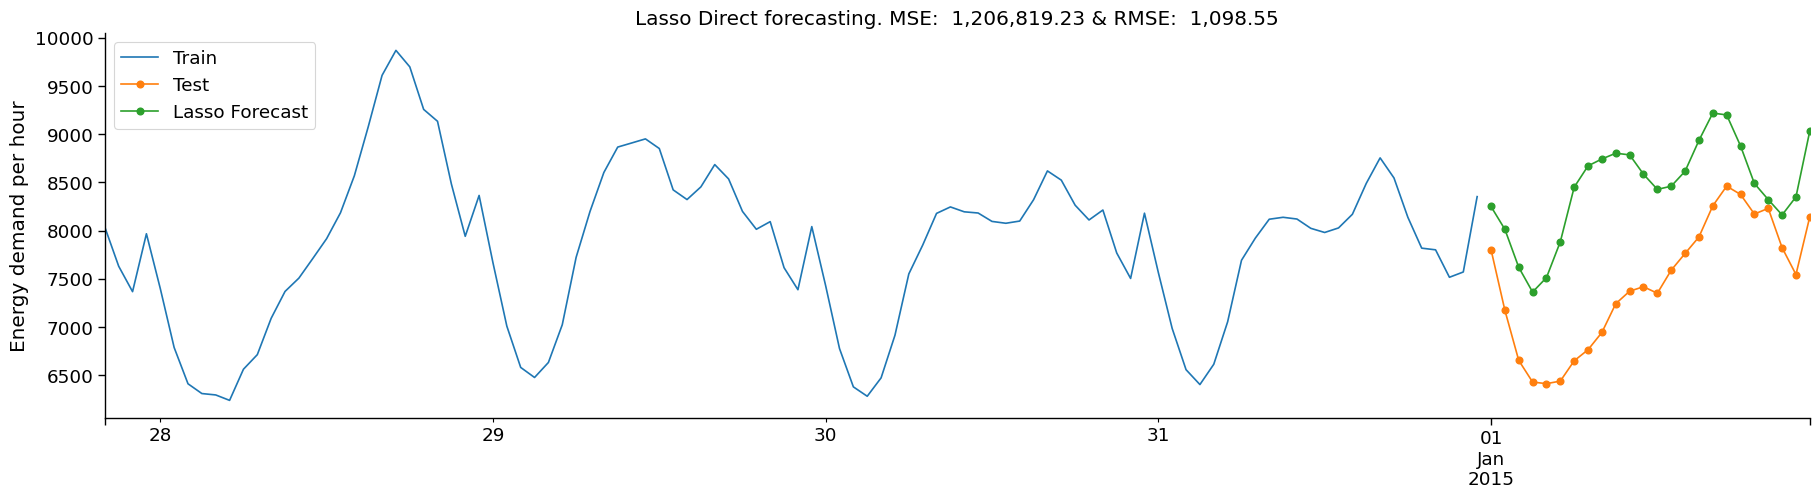

In [23]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )


fig, ax = plt.subplots()

X_train.tail(100).plot(ax=ax)
X_test.head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Train", "Test", "Lasso Forecast"])
plt.title(f"Lasso Direct forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

In [25]:
# Say we want to predict energy demand for 1st of February
forecast_start = '2015-02-01 00:00:00'

# we need the energy demand up to 144 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(forecaster.window_size)

# for the exog
exog = pd.DataFrame(
    X_test['2015-01-31 23:59:59':].head(HORIZON).index,
    columns = ["date_time"],
    index = X_test['2015-01-31 23:59:59':].head(HORIZON).index,
)

exog

,date_time
date_time,
2015-02-01 00:00:00,2015-02-01 00:00:00
2015-02-01 01:00:00,2015-02-01 01:00:00
2015-02-01 02:00:00,2015-02-01 02:00:00
2015-02-01 03:00:00,2015-02-01 03:00:00
2015-02-01 04:00:00,2015-02-01 04:00:00
2015-02-01 05:00:00,2015-02-01 05:00:00
2015-02-01 06:00:00,2015-02-01 06:00:00
2015-02-01 07:00:00,2015-02-01 07:00:00
2015-02-01 08:00:00,2015-02-01 08:00:00


In [27]:
predictions = forecaster.predict(
    steps=24,
    last_window=past_data_available["demand"],
    exog=exog,
)

pd.DataFrame(predictions).reset_index()

,index,pred
0,2015-02-01 00:00:00,"8,027.9593"
1,2015-02-01 01:00:00,"7,707.3879"
2,2015-02-01 02:00:00,"7,200.5739"
3,2015-02-01 03:00:00,"6,922.7103"
4,2015-02-01 04:00:00,"6,970.1687"
5,2015-02-01 05:00:00,"7,218.3816"
6,2015-02-01 06:00:00,"7,631.2682"
7,2015-02-01 07:00:00,"7,871.0456"
8,2015-02-01 08:00:00,"8,044.7119"
9,2015-02-01 09:00:00,"8,157.0168"


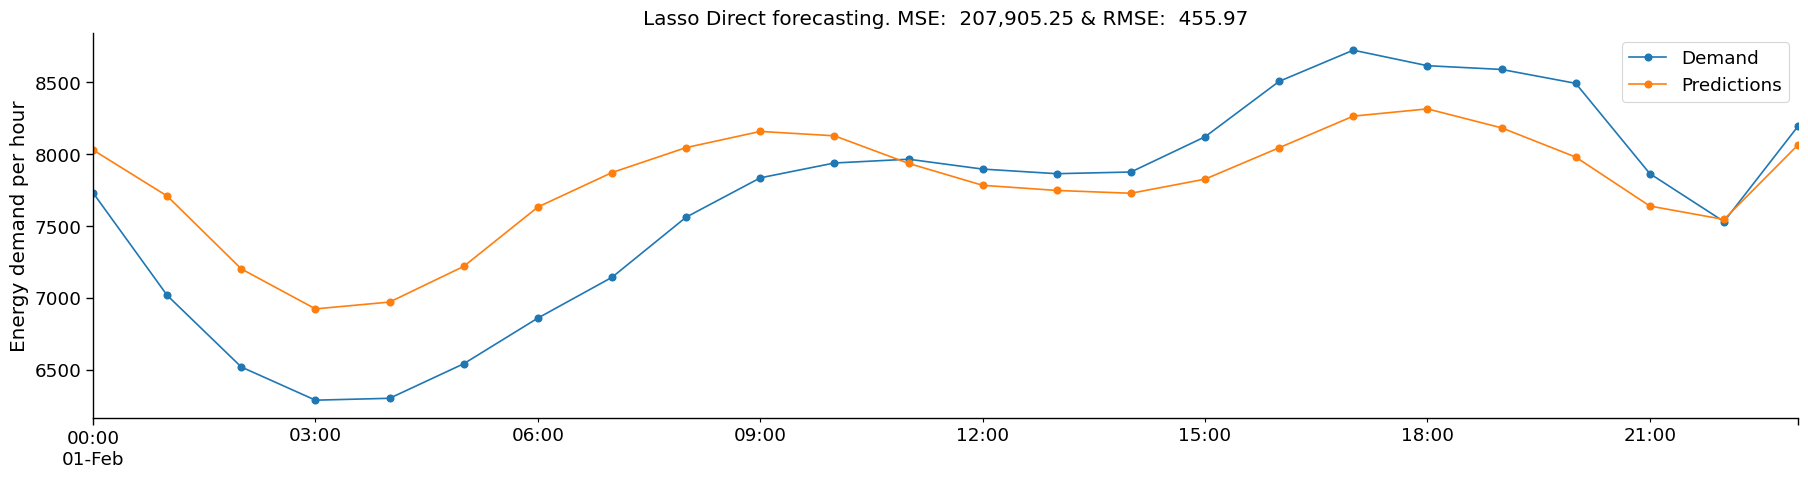

In [28]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_test['2015-01-31 23:59:59':].head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Demand", "Predictions"])
plt.title(f"Lasso Direct forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()